<a href="https://colab.research.google.com/github/Cksdud123/colab/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [228]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [229]:
import cv2
import numpy as np
from PIL import Image
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [230]:
# 정상 데이터
train_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/train/good/*')
# 이상 데이터들
test_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/broken_large/*')
test_dir_broken_small = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/broken_small/*')
test_dir_contamination = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/contamination/*')

# 정상 테스트 데이터
test_dir_good = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/good/*')

In [231]:
train_images = []
train_labels = []
test_images = []
test_labels = []
test_images_good = []
test_labels_good = []
target_size = (224, 224)

In [232]:
# 데이터셋 내의 모든 이미지 파일에 대해 resize 작업과 픽셀 값 정규화 작업
# 이미지 로드 및 리사이징
for img_path in train_dir:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    train_images.append(normalized_img_array)
    train_labels.append(0)

for img_path in test_dir + test_dir_broken_small + test_dir_contamination:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    test_images.append(normalized_img_array)
    test_labels.append(1)

In [233]:
for img_path in test_dir_good:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    test_images_good.append(normalized_img_array)
    test_labels_good.append(0)

In [234]:
# 정상 데이터가 들어있는 훈련용 데이터세트
train_dir = train_dir
# 이상 데이터가 들어있는 훈련용 데이터세트
test_dir = test_dir + test_dir_broken_small + test_dir_contamination
# 정상 데이터만 들어가있는 테스트용 데이터세트
test_dir_good = test_dir_good

In [235]:
# 랜덤 시드 설정
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# 정상과 비정상 데이터를 합친 전체 데이터셋
all_images = train_images + test_images
all_labels = train_labels + test_labels
# 테스트를 위한 정상 데이터세트가 들어있는 데이터셋
test_dir_good
# 데이터를 훈련 세트와 검증 세트로 분리
train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                      all_labels,
                                                                      test_size=0.2,
                                                                      random_state=42)

In [243]:
# 클래스 수 (이진 분류 - 정상: 0, 비정상: 1)
num_classes = 1
# ResNet-50 모델 불러오기 (pre-trained 가중치 사용)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 fully connected layer 추가하기
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # 드롭아웃 적용 (0.5는 드롭아웃 비율로 50%의 뉴런을 랜덤하게 비활성화)
predictions = Dense(num_classes, activation='sigmoid')(x)  # 이진 분류이므로 activation을 sigmoid로 변경

# 전체 모델 정의하기
model = Model(inputs=base_model.input, outputs=predictions)

In [244]:
# 기존의 ResNet-50 모델 가중치 동결하기
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일하기
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [245]:
# numpy배열로 변환
train_images = np.array(train_images)
val_images = np.array(val_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [250]:
# 모델 훈련하기
epochs = 20
history = model.fit(train_images, train_labels, epochs=epochs, validation_split=0.2)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/20
6/6 [==============================] - 1s 139ms/step - loss: 0.5411 - accuracy: 0.7861 - val_loss: 0.6463 - val_accuracy: 0.6818
Epoch 2/20
6/6 [==============================] - 1s 122ms/step - loss: 0.5472 - accuracy: 0.7803 - val_loss: 0.6449 - val_accuracy: 0.6818
Epoch 3/20
6/6 [==============================] - 1s 124ms/step - loss: 0.5264 - accuracy: 0.7803 - val_loss: 0.6534 - val_accuracy: 0.6818
Epoch 4/20
6/6 [==============================] - 1s 121ms/step - loss: 0.5181 - accuracy: 0.7861 - val_loss: 0.6585 - val_accuracy: 0.6818
Epoch 5/20
6/6 [==============================] - 1s 122ms/step - loss: 0.5313 - accuracy: 0.7919 - val_loss: 0.6535 - val_accuracy: 0.6818
Epoch 6/20
6/6 [==============================] - 1s 119ms/step - loss: 0.5258 - accuracy: 0.7919 - val_loss: 0.6430 - val_accuracy: 0.6818
Epoch 7/20
6/6 [==============================] - 1s 123ms/step - loss: 0.5134 - accuracy: 0.7919 - val_loss: 0.6417 - val_accuracy: 0.6818
Epoch 8/20
6/6 [====

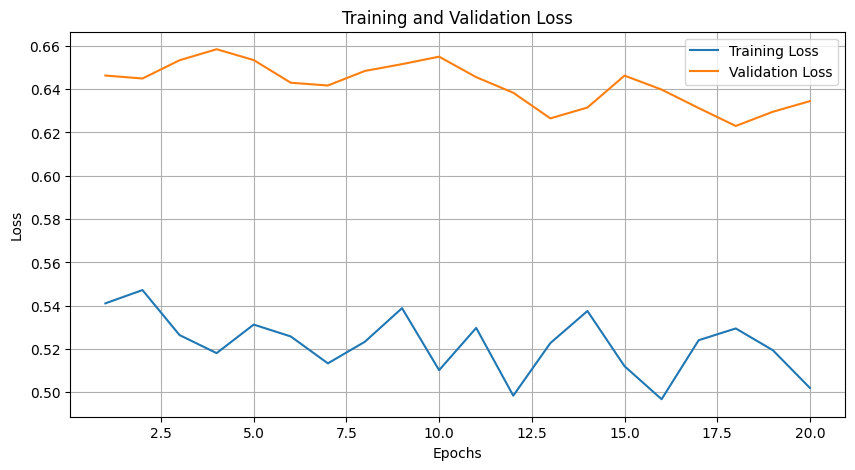

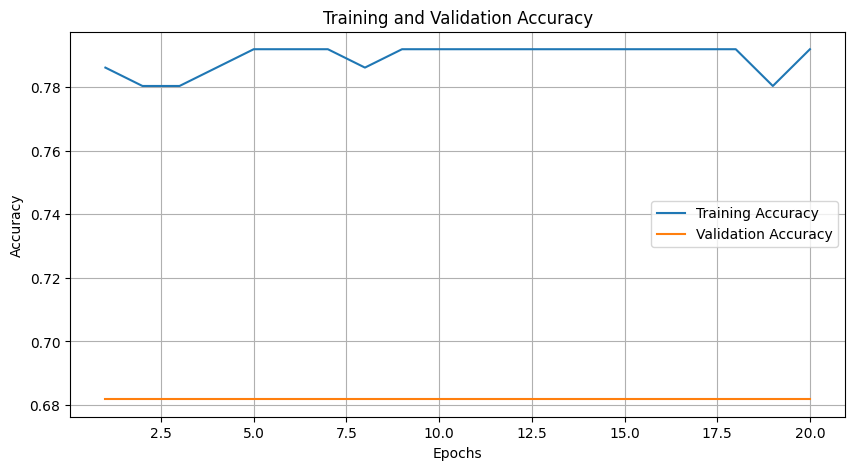

In [251]:
# 학습 결과를 기록한 history 객체에서 Loss와 Accuracy 추출
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Epoch 수
epochs_range = range(1, epochs + 1)

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

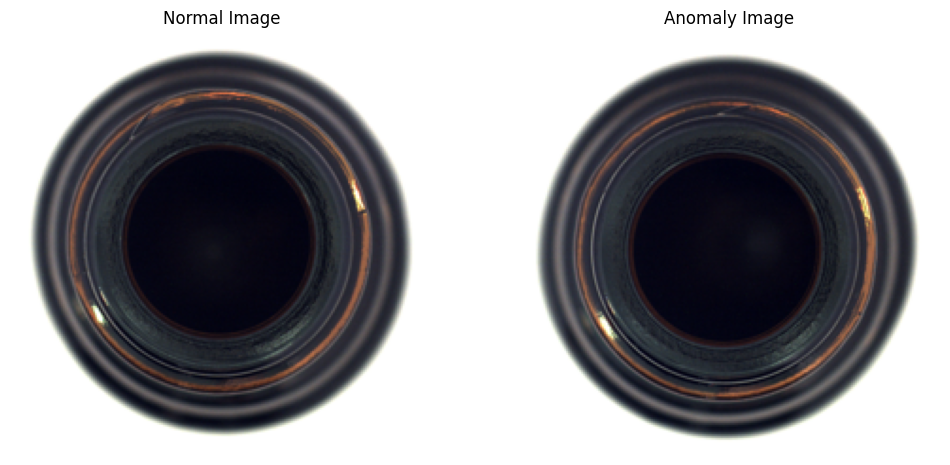

In [252]:
# 정상 데이터셋과 비정상 데이터셋 분리
# 정상 데이터는 0 이상 데이터는 1로 표현
normal_images = [img for img, label in zip(all_images, all_labels) if label == 0]
anomaly_images = [img for img, label in zip(all_images, all_labels) if label == 1]

# 랜덤하게 이미지 시각화하여 비교하기
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(normal_images[np.random.randint(len(normal_images))])
plt.title('Normal Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(anomaly_images[np.random.randint(len(anomaly_images))])
plt.title('Anomaly Image')
plt.axis('off')

plt.show()